# Contents
- [Data-Setup](#Data-Setup)
- [Randomization Methods](#Randomization-Methods)
- [AA Testing](#AA-Testing)
    - [SRM Check](#SRM-Check)
- [Power Analysis](#Power-Analysis)
- [AB Testing](#AB-Testing)
- [Results](#Results)
    - [Summary](#Conversion-Rates)
    - [Visualization](#Visualization)
    - [Confidence Intervals Within Groups](#Confidence-Intervals-Outcomes)
    - [Confidence Intervals Across Groups](#Confidence-Intervals-Difference)
    - [Conclusion](#Conclusion)
- [How Long](#How-Long)
- [Post Hoc Analysis](#Post-Hoc-Analysis)
    - [Segmented Lift](#Segmented-Lift)
    - [Gaurdrail Metrics](#Gaurdrail-Metrics)
    - [Rollout Simulation](#Rollout-Simulation)
- [Other Notes](#Other-Notes)
    - [Experimentation-Infrastructure](#Experimentation-Infrastructure)
- [Scratch Notes](#Scratch-Notes)
    - [Other Use Cases](#Other-Use-Cases)

<details>
<summary><strong>🧪 A/B Test - Decision Flow (click to expand)</strong></summary>

```
[What is your outcome type?]  
   |  
   +--> Binary (e.g., converted = 1 or 0, clicked or not)  
   |     |  
   |     +--> What are you comparing?  
   |           |  
   |           +--> Proportions (e.g., 10% vs 12% conversion rate)  
   |           |     |  
   |           |     +--> Comparing 2 groups ---------> Use Z-test  
   |           |     |                                 Compares success rates (proportions) between 2 groups  
   |           |     +--> Comparing 3+ groups --------> Use Chi-Square Test  
   |           |                                       Tests whether at least one group’s success rate differs; follow with pairwise Z-tests  
   |           +--> Counts (e.g., number of users who converted)  
   |                 +--> Comparing 2 groups ---------> Use Chi-Square Test  
   |                 +--> Comparing 3+ groups --------> Use Chi-Square Test  
   |  
   +--> Continuous (e.g., revenue, time spent, items bought)  
   |     +--> Comparing 2 groups  
   |     |     +--> Are the groups made of different users?  
   |     |           +--> Yes  
   |     |           |     +--> Is the outcome roughly normal?  
   |     |           |           +--> Yes ------------> Use Independent T-test  
   |     |           |           +--> No -------------> Use Mann-Whitney U Test  
   |     |           +--> No (same users before/after)  
   |     |                 +--> Is the outcome roughly normal?  
   |     |                       +--> Yes ------------> Use Paired T-test  
   |     |                       +--> No -------------> Use Wilcoxon Signed-Rank Test  
   |     +--> Comparing 3+ groups --------------------> Use ANOVA  
   |  
   +--> Categorical (e.g., selected A/B/C option)  
         +--> Comparing 2 or more groups -------------> Use Chi-Square Test  

[Other Scenarios]  
   +--> Want to control for other variables? ---------> Use Regression (Linear or Logistic)  
   +--> Prefer probability over p-values? ------------> Use Bayesian A/B Testing  

</details>


<details> <summary><strong>📊 A/B Test - Decision Flow Flattened Table (click to expand) </strong></summary>
    
| Outcome Type | What Are You Comparing?          | Group Count | Group Structure | Outcome Distribution | Statistical Test        | What It Does                                             | Example Problem Statement |
|--------------|----------------------------------|-------------|------------------|-----------------------|--------------------------|----------------------------------------------------------|----------------------------|
| Binary        | Proportions (% converted)        | 2           | Independent      | N/A                   | Z-test                   | Compares proportions between 2 groups                    | Does the new homepage increase conversion from 10% to 12%? |
| Binary        | Proportions                      | 3+          | Independent      | N/A                   | Chi-Square               | Tests if at least one group’s conversion rate differs    | Is there a significant difference in conversion across blue/orange/green CTA? |
| Binary        | Counts (e.g., #converted users)  | 2           | Independent      | N/A                   | Chi-Square               | Compares success/failure counts between groups           | Did 120 out of 1000 in group A convert vs 150 out of 1000 in group B? |
| Binary        | Counts                           | 3+          | Independent      | N/A                   | Chi-Square               | Compares categorical counts across multiple groups       | Do different signup flows lead to different conversion counts? |
| Continuous    | Mean of a metric (e.g., revenue) | 2           | Independent      | Normal                | Independent T-test       | Compares average outcome across 2 independent groups     | Does average order value differ between control and treatment? |
| Continuous    | Mean of a metric                 | 2           | Independent      | Not normal            | Mann-Whitney U           | Compares ranks/distributions between 2 independent groups| Is time-on-site higher in treatment group (skewed data)? |
| Continuous    | Before vs After (same users)     | 2           | Paired           | Normal                | Paired T-test            | Compares mean change for same users before and after     | Did users spend more on their second visit after UI update? |
| Continuous    | Before vs After (same users)     | 2           | Paired           | Not normal            | Wilcoxon Signed-Rank     | Compares paired non-normal outcomes                      | Did session duration increase for the same users post-change? |
| Continuous    | Mean outcome                     | 3+          | Independent      | Any                   | ANOVA                    | Compares means across 3 or more groups                   | Does average basket size differ across A/B/C pricing variants? |
| Categorical   | User-selected categories         | 2+          | Independent      | N/A                   | Chi-Square               | Tests distribution of categories across groups           | Do users pick different plans (Basic, Pro, Premium) across test groups? |
| Any           | Adjusting for other variables    | Any         | Any              | N/A                   | Regression (Linear/Logistic) | Measures treatment effect while controlling for covariates | Is treatment still effective after accounting for device and region? |
| Any           | Prefer probability > p-value     | Any         | Any              | N/A                   | Bayesian A/B Test        | Returns probability one group is better than the other   | What’s the probability green button outperforms blue? |
| Binary (Paired) | Conversion before vs after (same users) | 2     | Paired           | N/A                   | McNemar’s Test           | Tests change in conversion for same users                | Did logged-in users convert more after design change? |  
</details>

<details> <summary><strong>📊 When to Use Which Statistical Test in A/B Testing </strong></summary>

#### 🧪 When to Use Which Statistical Test in A/B Testing

| **Metric Type**        | **Example**                        | **Recommended Test**                      | **Why**                                                  |
|------------------------|------------------------------------|-------------------------------------------|-----------------------------------------------------------|
| Continuous             | Revenue, time on site, scores      | `scipy.stats.ttest_ind` (T-test)          | Compares means of two independent groups                 |
| Continuous (unequal variance) | Same as above               | `ttest_ind(..., equal_var=False)`         | Welch’s T-test — safer when variances differ             |
| Binary (0/1 outcomes)  | Conversion, click, purchase        | `statsmodels.stats.proportions_ztest`     | Compares proportions between two groups                  |
| Count data             | # pageviews, # items bought        | Poisson or Negative Binomial test         | For skewed count distributions                           |
| Non-parametric         | Ordinal/skewed data, NPS scores    | Mann-Whitney U test                       | No assumption of normality                               |
| Multiple groups (A/B/C)| Multi-variant tests                | ANOVA (continuous), Chi-squared (binary)  | Tests across 3+ groups                                   |

---

#### ✅ Quick Rules of Thumb:
- If your metric is **continuous + normal-ish** → Use **T-test**
- If it’s **binary (e.g., clicked or not)** → Use **Z-test**
- If it’s **non-normal or skewed** → Use **Mann-Whitney U test**
- If testing **3 or more variants** → Use **ANOVA** or **Chi-squared**

</details>

# Data Setup

In [1]:
# Display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, ttest_ind, ttest_rel, mannwhitneyu
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower, TTestPower, FTestAnovaPower

# Set Seed 
my_seed=42
np.random.seed(my_seed)

##### Test Type

In [2]:
experiment_type = 'binary'  # options: 'binary', 'continuous_independent', 'continuous_paired', 'categorical'

# Options:
#   'binary'                 → Comparing proportions (e.g., conversion rate) between 2 groups — uses Z-test
#   'continuous_independent' → Comparing means of a continuous metric between 2 independent groups — uses T-test
#   'continuous_paired'      → Comparing means of a continuous metric within the same users (e.g., before vs after) — uses Paired T-test
#   'categorical'            → Comparing distribution of categorical outcomes across 2 groups — uses Chi-Square Test

##### Sample user data

In [3]:
observations_count = 1000

np.random.seed(my_seed)  # For reproducibility
users = pd.DataFrame({
    'user_id': range(1, observations_count+1),
    'platform': np.random.choice(['iOS', 'Android'], size=observations_count, p=[0.6, 0.4]),  # 60% iOS, 40% Android
    'engagement_score': np.random.normal(50, 15, observations_count),  # Simulated user engagement scores
    'city': np.random.choice(['ny', 'sf', 'chicago', 'austin'], size=observations_count),
    'past_purchase_count': np.random.normal(loc=50, scale=10, size=observations_count)  # pre_experiment_metric for CUPED randomization
})
users

,user_id,platform,engagement_score,city,past_purchase_count
0,1,iOS,52.665515,ny,34.018756
1,2,Android,29.969835,ny,54.621727
2,3,Android,55.702968,ny,70.243096
3,4,iOS,59.158786,ny,36.368260
4,5,iOS,58.396857,ny,51.897062
...,...,...,...,...,...
995,996,iOS,30.199662,sf,63.305749
996,997,Android,40.823464,chicago,38.032114
997,998,iOS,49.444448,chicago,58.936977
998,999,Android,43.560467,austin,58.929539


[Back to the top](#Contents)
___


# Randomization Methods

Randomization is used to ensure that observed differences in outcome metrics are due to the experiment, not pre-existing differences.

- Prevents **selection bias** (e.g., users self-selecting into groups)  
- Balances **confounding factors** like platform, region, or past behavior  
- Enables **valid inference** through statistical testing

### 🎯 Simple Randomization  
Each user is assigned to control or treatment with **equal probability**, independent of any characteristics.

##### When to Use
- Sample size is **large enough** to ensure natural balance  
- No strong concern about **confounding variables**  
- Need a **quick, default assignment** strategy

##### How It Works
- Assign each user randomly (e.g., 50/50 split)  
- No grouping, segmentation, or blocking involved  
- Groups are expected to balance out on average  

In [4]:
def apply_simple_randomization(df, group_col='group', seed=my_seed):
    """
    Randomly assigns each row to 'control' or 'treatment' with equal probability.

    Parameters:
    - df: pandas DataFrame containing observations
    - group_col: name of the column to store group assignments
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with an added group assignment column
    """
    np.random.seed(seed)
    df[group_col] = np.random.choice(['control', 'treatment'], size=len(df), p=[0.5, 0.5])
    return df

### Stratified Sampling  
Ensures that key segments (e.g., platform, region) are evenly represented across control and treatment.

##### When to Use
- User base is **naturally skewed** (e.g., 70% mobile, 30% desktop)  
- Important to control for **known confounders** like geography or device  
- You want balance **within subgroups**, not just overall

##### How It Works
- Pick a stratification variable (e.g., platform)  
- Split population into strata (groups)  
- Randomly assign users **within each stratum**  

In [5]:
def apply_stratified_randomization(df, stratify_col, group_col='group', seed=my_seed):
    """
    Performs stratified randomization to ensure balanced assignment across a key segment.

    Parameters:
    - df: pandas DataFrame to assign groups to
    - stratify_col: column to balance across (e.g., platform, region)
    - group_col: name of the column to store group assignments
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with assigned groups, balanced across stratification column
    """
    # Split data into control and treatment while preserving distribution of the stratify column
    train, test = train_test_split(df, test_size=0.5, stratify=df[stratify_col], random_state=seed)

    # Assign groups manually
    train[group_col] = 'control'
    test[group_col] = 'treatment'

    # Combine and preserve original order (by index)
    return pd.concat([train, test]).sort_index()

### Block Randomization  
Groups users into fixed-size blocks and randomly assigns groups within each block.

##### When to Use
- Users arrive in **time-based batches** (e.g., daily cohorts)  
- Sample size is **small** and needs enforced balance  
- You want to minimize **temporal or ordering effects**

##### How It Works
- Create blocks based on order or ID (e.g., every 10 users)  
- Randomize assignments **within each block**  
- Ensures near-equal split in every batch  

In [6]:
def apply_block_randomization(
    df,
    observation_id_col,
    group_col='group',
    block_size=10,
    seed=42
):
    """
    Assigns treatment/control groups using block randomization.

    Parameters:
    - df: DataFrame to modify
    - observation_id_col: Unique row identifier (e.g., user_id, session_id)
    - group_col: Column to assign groups into
    - block_size: Number of observations per block
    - seed: Random seed for reproducibility

    Returns:
    - DataFrame with assigned group_col
    """
    np.random.seed(seed)

    df[group_col] = (
        df
        .assign(_block=(df[observation_id_col] - 1) // block_size)
        .groupby('_block')[observation_id_col]
        .transform(lambda x: np.random.choice(['control', 'treatment'], size=len(x), replace=True))
    )

    # Drop the block column if you want — optional
    # df = df.drop(columns=['_block'])

    return df

### Match Pair Randomization

Participants are **paired based on similar characteristics** before random group assignment.  
This reduces variance and improves **statistical power** by ensuring balance on key covariates.

##### When to Use
- Small sample size with high risk of **confounding**
- Outcomes influenced by user traits (e.g., **age, income, tenure**)  
- Need to **minimize variance** across groups

##### How It Works
1. Identify important covariates (e.g., age, purchase history)  
2. Sort users by those variables  
3. Create matched pairs (or small groups)  
4. Randomly assign one to **control**, the other to **treatment**  

In [7]:
def apply_matched_pair_randomization(df, sort_col, group_col='group'):
    """
    Assigns groups using matched-pair randomization based on a sorting variable.

    Parameters:
    - df: pandas DataFrame to assign groups to
    - sort_col: column used to sort users before pairing (e.g., engagement score)
    - group_col: name of the column to store group assignments

    Returns:
    - DataFrame with alternating control/treatment assignments within sorted pairs
    """
    # Sort by the matching variable to bring similar observations together
    df = df.sort_values(by=sort_col).reset_index(drop=True)

    # Alternate assignments to create matched pairs (control, treatment, control, ...)
    df[group_col] = np.where(df.index % 2 == 0, 'control', 'treatment')

    return df

### Cluster Randomization
Entire **groups or clusters** (e.g., cities, stores, schools) are assigned to control or treatment.  
Used when it's impractical or risky to randomize individuals within a cluster.

###### When to Use
- Users naturally exist in **groups** (e.g., teams, locations, devices)
- There's a risk of **interference** between users (e.g., word-of-mouth)
- Operational or tech constraints prevent individual-level randomization

###### How It Works
1. Define the cluster unit (e.g., store, city)  
2. Randomly assign each cluster to control or treatment  
3. All users within the cluster inherit the group assignment  

In [8]:
def apply_cluster_randomization(df, cluster_col, group_col='group', seed=my_seed):
    """
    Assigns groups using cluster-level randomization, where all observations in a cluster
    receive the same assignment.

    Parameters:
    - df: pandas DataFrame to assign groups to
    - cluster_col: column defining the cluster (e.g., city, store)
    - group_col: name of the column to store group assignments
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with group assignments applied at the cluster level
    """
    np.random.seed(seed)

    # Randomly assign each cluster to control or treatment
    unique_clusters = df[cluster_col].unique()
    cluster_assignments = dict(
        zip(unique_clusters, np.random.choice(['control', 'treatment'], size=len(unique_clusters)))
    )

    # Map cluster-level assignments back to the full dataset
    df[group_col] = df[cluster_col].map(cluster_assignments)

    return df

### CUPED (Controlled Pre-Experiment Data)
A statistical adjustment that uses **pre-experiment behavior** to reduce variance and improve power.  
It helps detect smaller effects without increasing sample size.

##### When to Use
- You have reliable **pre-experiment metrics** (e.g., past spend, engagement)
- You want to **reduce variance** and improve test sensitivity
- You’re dealing with **small lifts** or **costly sample sizes**

##### How It Works
1. Identify a pre-period metric **correlated with your outcome**
2. Use regression to compute an adjustment (theta)  
3. Subtract the correlated component from your outcome metric  
4. Analyze the adjusted metric instead of the raw one  

In [9]:
def apply_cuped(df, pre_metric, group_col='group', outcome_col='adjusted_outcome', seed=my_seed):
    """
    Applies CUPED (Controlled Pre-Experiment Data) adjustment to reduce variance
    using a pre-experiment covariate.

    Parameters:
    - df: pandas DataFrame to assign groups and compute adjusted outcomes
    - pre_metric: name of the pre-experiment covariate column
    - group_col: name of the column to store group assignments
    - outcome_col: name of the new column to store the CUPED-adjusted outcome
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with random assignment and adjusted outcome using CUPED
    """
    np.random.seed(seed)

    # Perform simple randomization (required before applying CUPED)
    df = apply_simple_randomization(df.copy(), group_col=group_col, seed=seed)

    # Simulate experiment outcome (in practice, this would be your actual metric)
    y = np.random.normal(loc=0, scale=5, size=len(df))

    # Regress outcome on pre-experiment metric to estimate theta (correction factor)
    X = sm.add_constant(df[[pre_metric]])
    theta = sm.OLS(y, X).fit().params[pre_metric]

    # Apply CUPED adjustment: reduce outcome variance using theta * pre-metric
    df[outcome_col] = y - theta * df[pre_metric]

    return df

In [10]:
method_map = {
    "simple": lambda df: apply_simple_randomization(df),
    "stratified": lambda df: apply_stratified_randomization(df, stratify_col='platform'),
    "block": lambda df: apply_block_randomization(users, observation_id_col='user_id', block_size=10),    
    "matched_pair": lambda df: apply_matched_pair_randomization(df, sort_col='engagement_score'),
    "cluster": lambda df: apply_cluster_randomization(df, cluster_col='city'),
    "cuped": lambda df: apply_cuped(df, pre_metric='past_purchase_count'),
}

randomization_method="simple"
if randomization_method not in method_map:
    raise ValueError(f"❌ Unsupported method: {randomization_method}")
    
users = method_map[randomization_method](users)
users

,user_id,platform,engagement_score,city,past_purchase_count,group
0,1,iOS,52.665515,ny,34.018756,control
1,2,Android,29.969835,ny,54.621727,treatment
2,3,Android,55.702968,ny,70.243096,treatment
3,4,iOS,59.158786,ny,36.368260,treatment
4,5,iOS,58.396857,ny,51.897062,control
...,...,...,...,...,...,...
995,996,iOS,30.199662,sf,63.305749,control
996,997,Android,40.823464,chicago,38.032114,treatment
997,998,iOS,49.444448,chicago,58.936977,control
998,999,Android,43.560467,austin,58.929539,treatment


[Back to the top](#Contents)
___


# AA Testing

A/A testing is a **preliminary experiment** where both groups (e.g., “control” and “treatment”) receive the exact same experience. It's used to validate the experimental setup before running an actual A/B test.

##### What Are We Checking?
- Are users being assigned fairly and randomly?
- Are key outcome metrics statistically similar across groups?
- Can we trust the experimental framework?

##### Why A/A Testing Matters
- **Validates Randomization**  
  Confirms the groups are balanced at baseline (no bias or leakage)
  
- **Detects SRM (Sample Ratio Mismatch)**  
  Ensures the actual split (e.g., 50/50) matches what was intended
  
- **Estimates Variability**  
  Helps calibrate variance for accurate power calculations later
  
- **Trust Check**  
  Catches bugs in assignment logic, event tracking, or instrumentation

##### A/A Test Process

1. **Randomly assign users** into two equal groups  
   Just like you would for an A/B test (e.g., control vs treatment)

2. **Measure key outcome**  
   This depends on your experiment type:  
   - `binary` → conversion rate  
   - `continuous` → avg. revenue, time spent  
   - `categorical` → feature adoption, plan selected

3. **Run statistical test**  
   - `binary` → Z-test or Chi-square  
   - `continuous` → t-test  
   - `categorical` → Chi-square test

4. **Check SRM**  
   Use a chi-square goodness-of-fit test to detect assignment imbalances

##### Possible Outcomes
| Result                            | Interpretation                                     |
|-----------------------------------|----------------------------------------------------|
| No significant difference         | ✅ Randomization looks good. Test setup is sound.  |
| Statistically significant difference | ⚠️ Something’s off — check assignment logic, instrumentation, or sample leakage |

*Run A/A tests whenever you launch a new experiment framework, roll out a new randomizer, or need to build stakeholder trust.*


##### SRM Check 

Is group assignment balanced?
- SRM (Sample Ratio Mismatch) checks whether the observed group sizes match the expected ratio.
- In a perfect world, random assignment to 'A1' and 'A2' should give ~50/50 split.
- SRM helps catch bugs in randomization, data logging, or user eligibility filtering.

##### Real-World Experiment Split Ratios
| **Scenario**                     | **Split**              | **Why**                                 |
|----------------------------------|------------------------|------------------------------------------|
| Default A/B                      | 50 / 50                | Maximizes power and ensures fairness     |
| Risky feature                    | 10 / 90 or 20 / 80     | Limits user exposure to minimize risk    |
| Ramp-up                          | Step-wise (1-5-25-50…) | Gradual rollout to catch issues early    |
| A/B/C Test                       | 33 / 33 / 33 or weighted | Compare multiple variants fairly or with bias |
| High control confidence needed   | 70 / 30 or 60 / 40     | More stability in baseline comparisons   |

In [11]:
# from scipy import stats
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def run_aa_testing_generalized(
#     df,
#     group_col='group',
#     metric_col='engagement_score',
#     group_labels=('control', 'treatment'),
#     experiment_type='continuous_independent',
#     alpha=0.05,
#     visualize=True
# ):
#     """
#     Generalized A/A testing function to validate randomization for different types of experiment outcomes.

#     Parameters:
#     - df: DataFrame containing experimental data
#     - group_col: Column with group assignment
#     - metric_col: Column with outcome/metric to compare
#     - group_labels: Tuple of group labels to compare (default: ('control', 'treatment'))
#     - experiment_type: One of ['binary', 'continuous_independent', 'continuous_paired', 'categorical']
#     - alpha: Significance level (default 0.05)
#     - visualize: Show histogram if continuous
#     """
#     print(f"\n📊 A/A Test Summary for metric: '{metric_col}' [{experiment_type}]\n")

#     # --- SRM CHECK ---
#     print("🔍 Sample Ratio Mismatch (SRM) Check")
#     observed_counts = df[group_col].value_counts().reindex(group_labels, fill_value=0)
#     expected_counts = [len(df) / 2] * 2

#     for grp in group_labels:
#         count = observed_counts[grp]
#         pct = count / len(df) * 100
#         print(f"Group {grp}: {count} users ({pct:.2f}%)")

#     chi2_stat, chi2_p = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
#     print(f"\nChi2 Statistic: {chi2_stat:.4f}")
#     print(f"P-value: {chi2_p:.4f}")
#     if chi2_p < alpha:
#         print("⚠️ SRM Detected — investigate group assignment.\n")
#     else:
#         print("✅ No SRM — group sizes look balanced.\n")

#     # --- OUTCOME SIMILARITY CHECK (A/A TEST ON OUTCOME METRIC) ---
#     print("📏 Outcome Similarity Check")

#     group1 = df[df[group_col] == group_labels[0]][metric_col]
#     group2 = df[df[group_col] == group_labels[1]][metric_col]
#     test_name = ""
#     p_value = None

#     if experiment_type == 'binary':
#         conv1 = group1.mean()
#         conv2 = group2.mean()
#         n1, n2 = len(group1), len(group2)

#         pooled_prob = (group1.sum() + group2.sum()) / (n1 + n2)
#         se = np.sqrt(pooled_prob * (1 - pooled_prob) * (1/n1 + 1/n2))
#         z_score = (conv1 - conv2) / se
#         p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
#         test_name = "z-test for proportions"

#         print(f"Conversion Rate — {group_labels[0]}: {conv1:.4f}, {group_labels[1]}: {conv2:.4f}")
#         print(f"Z-score: {z_score:.4f}")
#         print(f"P-value: {p_value:.4f}")

#         # Interpretation
#         print("\n🧠 Interpretation:")
#         print(f"We used a {test_name} to evaluate whether the **conversion rate** differs between '{group_labels[0]}' and '{group_labels[1]}'.")
#         print("The null hypothesis (H₀) is that the **conversion rates** are the same.")
    
#     elif experiment_type == 'continuous_independent':
#         t_stat, p_value = stats.ttest_ind(group1, group2)
#         test_name = "independent t-test"
#         print(f"T-statistic: {t_stat:.4f}")
#         print(f"P-value: {p_value:.4f}")

#         # Interpretation
#         print("\n🧠 Interpretation:")
#         print(f"We used a {test_name} to test whether the average {metric_col} differs between '{group_labels[0]}' and '{group_labels[1]}'.")
#         print("The null hypothesis (H₀) assumes both groups have the same population mean.")
    
#     elif experiment_type == 'continuous_paired':
#         if len(group1) != len(group2):
#             print("❌ Paired t-test requires equal number of observations in each group.")
#             return
#         t_stat, p_value = stats.ttest_rel(group1, group2)
#         test_name = "paired t-test"
#         print(f"Paired T-statistic: {t_stat:.4f}")
#         print(f"P-value: {p_value:.4f}")

#         # Interpretation
#         print("\n🧠 Interpretation:")
#         print(f"We used a {test_name} to compare the {metric_col} across conditions for the same users.")
#         print("The null hypothesis (H₀) is that the **mean difference** between conditions is zero.")
    
#     elif experiment_type == 'categorical':
#         contingency = pd.crosstab(df[group_col], df[metric_col])
#         chi2, p_value, _, _ = stats.chi2_contingency(contingency)
#         test_name = "chi-square test"
#         print("Chi-square test on categorical outcome")
#         print(f"P-value: {p_value:.4f}")

#         # Interpretation
#         print("\n🧠 Interpretation:")
#         print(f"We used a {test_name} to check if the **distribution of {metric_col}** depends on group assignment.")
#         print("The null hypothesis (H₀) is that the distribution is **independent of the group**.")
    
#     else:
#         print(f"❌ Unsupported experiment_type: {experiment_type}")
#         return

#     # Common conclusion
#     print(f"\nWe use α = {alpha}, which means we're okay with a {alpha*100:.0f}% false positive rate.")
#     if p_value < alpha:
#         print(f"Since the p-value = {p_value:.4f} is **less than α**, we **reject the null hypothesis**.")
#         print(f"➡️ This suggests a statistically significant difference in {metric_col}.")
#     else:
#         print(f"Since the p-value = {p_value:.4f} is **greater than α**, we **fail to reject the null hypothesis**.")
#         print(f"➡️ No statistically significant difference detected in {metric_col}.")

#     # --- VISUALIZATION ---
#     if visualize:
#         if experiment_type.startswith('continuous'):
#             plt.hist(group1, bins=30, alpha=0.5, label=group_labels[0])
#             plt.hist(group2, bins=30, alpha=0.5, label=group_labels[1])
#             plt.title(f'AA Test: {metric_col} Distribution')
#             plt.xlabel(metric_col)
#             plt.ylabel('Frequency')
#             plt.legend()
#             plt.show()

#         elif experiment_type == 'binary':
#             rates = [group1.mean(), group2.mean()]
#             plt.bar(group_labels, rates)
#             for i, rate in enumerate(rates):
#                 plt.text(i, rate + 0.01, f"{rate:.2%}", ha='center')
#             plt.title(f'AA Test: Conversion Rate by Group')
#             plt.ylabel('Conversion Rate')
#             plt.ylim(0, 1)
#             plt.show()

#         elif experiment_type == 'categorical':
#             contingency = pd.crosstab(df[group_col], df[metric_col], normalize='index')
#             contingency.plot(kind='bar', stacked=True)
#             plt.title(f'AA Test: Distribution of {metric_col} by Group')
#             plt.ylabel('Proportion')
#             plt.xlabel(group_col)
#             plt.legend(title=metric_col)
#             plt.show()


In [12]:
def check_sample_ratio_mismatch(df, group_col, group_labels, alpha=0.05):
    print("🔍 Sample Ratio Mismatch (SRM) Check")
    observed_counts = df[group_col].value_counts().reindex(group_labels, fill_value=0)
    expected_counts = [len(df) / 2] * 2

    for grp in group_labels:
        count = observed_counts[grp]
        pct = count / len(df) * 100
        print(f"Group {grp}: {count} users ({pct:.2f}%)")

    chi2_stat, chi2_p = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
    print(f"\nChi2 Statistic: {chi2_stat:.4f}")
    print(f"P-value: {chi2_p:.4f}")
    if chi2_p < alpha:
        print("⚠️ SRM Detected — investigate group assignment.\n")
    else:
        print("✅ No SRM — group sizes look balanced.\n")


In [13]:
def run_outcome_similarity_test(group1, group2, experiment_type, group_labels, metric_col, alpha=0.05):
    print("📏 Outcome Similarity Check")

    if experiment_type == 'binary':
        conv1, conv2 = group1.mean(), group2.mean()
        n1, n2 = len(group1), len(group2)
        pooled_prob = (group1.sum() + group2.sum()) / (n1 + n2)
        se = np.sqrt(pooled_prob * (1 - pooled_prob) * (1/n1 + 1/n2))
        z_score = (conv1 - conv2) / se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
        print(f"Conversion Rate — {group_labels[0]}: {conv1:.4f}, {group_labels[1]}: {conv2:.4f}")
        print(f"Z-score: {z_score:.4f}")
        print(f"P-value: {p_value:.4f}")
        test_name = "z-test for proportions"

    elif experiment_type == 'continuous_independent':
        t_stat, p_value = stats.ttest_ind(group1, group2)
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        test_name = "independent t-test"

    elif experiment_type == 'continuous_paired':
        if len(group1) != len(group2):
            print("❌ Paired t-test requires equal number of observations in each group.")
            return None
        t_stat, p_value = stats.ttest_rel(group1, group2)
        print(f"Paired T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        test_name = "paired t-test"

    elif experiment_type == 'categorical':
        contingency = pd.crosstab(group1, group2)
        chi2, p_value, _, _ = stats.chi2_contingency(contingency)
        print("Chi-square test on categorical outcome")
        print(f"P-value: {p_value:.4f}")
        test_name = "chi-square test"

    else:
        print(f"❌ Unsupported experiment_type: {experiment_type}")
        return None

    # Interpretation
    print("\n🧠 Interpretation:")
    if experiment_type == 'binary':
        print(f"Used a {test_name} to compare conversion rates.")
        print("Null Hypothesis: conversion rates are the same.")
    elif experiment_type.startswith('continuous'):
        print(f"Used a {test_name} to compare means of '{metric_col}' across groups.")
        print("Null Hypothesis: average outcomes are the same.")
    elif experiment_type == 'categorical':
        print(f"Used a {test_name} to check if '{metric_col}' is independent of group.")
        print("Null Hypothesis: no relationship between group and category.")

    print(f"\nWe use α = {alpha:.2f}.")
    if p_value < alpha:
        print(f"➡️ p = {p_value:.4f} < α → Reject null hypothesis. Statistically significant difference.")
    else:
        print(f"➡️ p = {p_value:.4f} ≥ α → Fail to reject null. No significant difference.")
    
    return p_value


In [14]:
def visualize_aa_distribution(df, group1, group2, group_col, metric_col, experiment_type, group_labels):
    if experiment_type.startswith('continuous'):
        plt.hist(group1, bins=30, alpha=0.5, label=group_labels[0])
        plt.hist(group2, bins=30, alpha=0.5, label=group_labels[1])
        plt.title(f'AA Test: {metric_col} Distribution')
        plt.xlabel(metric_col)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show();

    elif experiment_type == 'binary':
        rates = [group1.mean(), group2.mean()]
        plt.bar(group_labels, rates)
        for i, rate in enumerate(rates):
            plt.text(i, rate + 0.01, f"{rate:.2%}", ha='center')
        plt.title(f'AA Test: Conversion Rate by Group')
        plt.ylabel('Conversion Rate')
        plt.ylim(0, 1)
        plt.show();

    elif experiment_type == 'categorical':
        contingency = pd.crosstab(df[group_col], df[metric_col], normalize='index')
        contingency.plot(kind='bar', stacked=True)
        plt.title(f'AA Test: Distribution of {metric_col} by Group')
        plt.ylabel('Proportion')
        plt.xlabel(group_col)
        plt.legend(title=metric_col)
        plt.show();


In [15]:
def run_aa_testing_generalized(
    df,
    group_col='group',
    metric_col='engagement_score',
    group_labels=('control', 'treatment'),
    experiment_type='continuous_independent',
    alpha=0.05,
    visualize=True
):
    print(f"\n📊 A/A Test Summary for metric: '{metric_col}' [{experiment_type}]\n")

    check_sample_ratio_mismatch(df, group_col, group_labels, alpha)

    group1 = df[df[group_col] == group_labels[0]][metric_col]
    group2 = df[df[group_col] == group_labels[1]][metric_col]

    p_value = run_outcome_similarity_test(group1, group2, experiment_type, group_labels, metric_col, alpha)

    if visualize and p_value is not None:
        visualize_aa_distribution(df, group1, group2, group_col, metric_col, experiment_type, group_labels)



📊 A/A Test Summary for metric: 'engagement_score' [continuous_independent]

🔍 Sample Ratio Mismatch (SRM) Check
Group control: 503 users (50.30%)
Group treatment: 497 users (49.70%)

Chi2 Statistic: 0.0360
P-value: 0.8495
✅ No SRM — group sizes look balanced.

📏 Outcome Similarity Check
T-statistic: 0.5567
P-value: 0.5779

🧠 Interpretation:
Used a independent t-test to compare means of 'engagement_score' across groups.
Null Hypothesis: average outcomes are the same.

We use α = 0.05.
➡️ p = 0.5779 ≥ α → Fail to reject null. No significant difference.


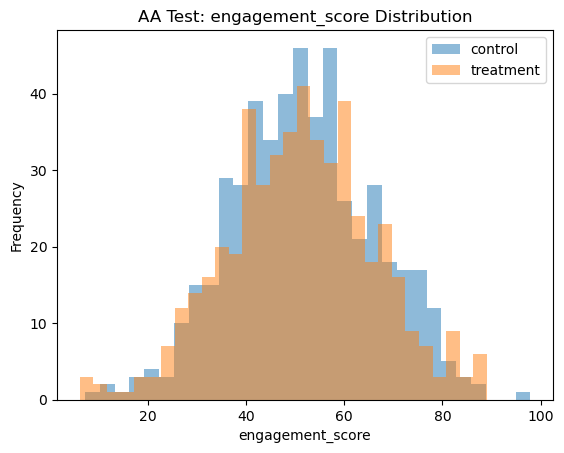

In [16]:
# For continuous metric like engagement_score
run_aa_testing_generalized(users, group_col='group', metric_col='engagement_score', experiment_type='continuous_independent')

# For binary outcome like converted (0/1)
# run_aa_testing_generalized(users, group_col='group', metric_col='converted', experiment_type='binary')

# For paired before/after measurements
# run_aa_testing_generalized(pre_post_df, group_col='group', metric_col='time_spent', experiment_type='continuous_paired')

# For categorical outcomes (e.g., plan type)
# run_aa_testing_generalized(users, group_col='group', metric_col='plan_type', experiment_type='categorical')

[Back to the top](#Contents)
___


# Power Analysis

Power analysis helps determine the **minimum sample size** required to detect a true effect with statistical confidence.

##### Why It Matters:
- Avoids **underpowered tests** (risk of missing real effects)
- Balances tradeoffs between Sample size, Minimum Detectable Effect (MDE), Significance level (α), Statistical power (1 - β)

##### Key Inputs:
| Parameter      | Meaning                                                   |
|----------------|------------------------------------------------------------|
| **alpha (α)**  | Significance level (probability of false positive), e.g. 0.05 |
| **Power (1 - β)** | Probability of detecting a true effect, e.g. 0.80 or 0.90 |
| **Baseline**   | Current outcome (e.g., 10% conversion, $50 revenue)         |
| **MDE**        | Minimum detectable effect — the smallest meaningful lift (e.g., +2% or +$5) |
| **Std Dev**    | Standard deviation of the metric (for continuous outcomes) |
| **Effect Size**| Optional: Cohen's d (for t-tests) or f (for ANOVA)         |
| **Groups**     | Number of groups (relevant for ANOVA)                      |

This notebook automatically selects the correct formula based on `experiment_type` variable.

In [17]:
from statsmodels.stats.power import (
    TTestIndPower,
    TTestPower,
    FTestAnovaPower,
    NormalIndPower
)
from scipy import stats
import numpy as np


def calculate_power_sample_size(
    experiment_type,
    alpha=0.05,
    power=0.80,
    baseline_rate=None,   # For binary: e.g., 0.10 = 10% conversion rate
    mde=None,             # Minimum Detectable Effect (absolute change)
                          # e.g., 0.02 for 2% lift in binary, or $5 increase in continuous
    std_dev=None,         # Std deviation of outcome for continuous outcomes
    effect_size=None,     # Cohen's d (for t-tests) or w (for chi-square)
    num_groups=2          # Only relevant for ANOVA (if ever extended)
):
    """
    Generalized sample size calculator for A/B testing based on experiment type.

    Parameters
    ----------
    experiment_type : str
        One of:
        - 'binary'                  : Binary outcome (Z-test on proportions)
        - 'continuous_independent' : Continuous outcome, different users (independent t-test)
        - 'continuous_paired'      : Continuous outcome, same users (paired t-test)
        - 'categorical'            : Categorical outcome (Chi-square test)

    alpha : float
        Significance level (Type I error), usually 0.05

    power : float
        Desired power of the test, e.g., 0.80 for 80%

    baseline_rate : float
        Required for binary test — e.g., 0.10 for 10% conversion rate

    mde : float
        Minimum detectable effect (absolute lift):
        - Binary: 0.02 → detect +2% lift
        - Continuous: 5 → detect $5 difference

    std_dev : float
        Required for continuous outcome tests (if effect_size not provided)

    effect_size : float
        Optional: Cohen’s d (t-tests) or Cohen’s w (Chi-square)

    num_groups : int
        Reserved for ANOVA extensions; not used in current version.

    Returns
    -------
    int
        Required sample size per group
    """

    # ----- 1. Binary Outcome -----
    if experiment_type == 'binary':
        if baseline_rate is None or mde is None:
            raise ValueError("baseline_rate and mde are required for binary tests.")
        
        z_alpha = stats.norm.ppf(1 - alpha / 2)
        z_beta = stats.norm.ppf(power)
        p1 = baseline_rate
        p2 = p1 + mde
        pooled_std = np.sqrt(2 * p1 * (1 - p1))

        n = ((z_alpha + z_beta) ** 2 * pooled_std ** 2) / (mde ** 2)
        return int(np.ceil(n))

    # ----- 2. Continuous (Independent Groups) -----
    elif experiment_type == 'continuous_independent':
        if std_dev is None and effect_size is None:
            raise ValueError("Provide std_dev or effect_size for continuous_independent test.")
        if effect_size is None:
            effect_size = mde / std_dev
        
        analysis = TTestIndPower()
        n = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
        return int(np.ceil(n))

    # ----- 3. Continuous (Paired Users) -----
    elif experiment_type == 'continuous_paired':
        if std_dev is None and effect_size is None:
            raise ValueError("Provide std_dev or effect_size for continuous_paired test.")
        if effect_size is None:
            effect_size = mde / std_dev

        analysis = TTestPower()
        n = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
        return int(np.ceil(n))

    # ----- 4. Categorical Outcome (Chi-square) -----
    elif experiment_type == 'categorical':
        if effect_size is None:
            raise ValueError("effect_size (Cohen's w) is required for categorical tests.")
        
        analysis = NormalIndPower()  # Approximate method
        n = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
        return int(np.ceil(n))

    else:
        raise ValueError(f"Unsupported experiment_type: {experiment_type}")


In [18]:
# 🎯 Experiment assumptions
experiment_type = 'binary'     # Options: 'binary', 'continuous_independent', 'continuous_paired', 'categorical'
alpha = 0.05                   # Type I error tolerance (false positive rate)
power = 0.80                   # 1 - β (probability of detecting a true effect)
baseline_rate = 0.10           # For binary: current conversion rate = 10%
mde = 0.02                     # Minimum detectable effect (e.g., +2% lift or +$5 increase)
std_dev = None                 # Required for continuous outcomes if effect_size is not provided
effect_size = None             # Optional: Cohen’s d (continuous) or w (categorical)
num_groups = None              # Not used currently; placeholder for future ANOVA extension

# 🧮 Sample size calculation
required_sample_size = calculate_power_sample_size(
    experiment_type=experiment_type,
    alpha=alpha,
    power=power,
    baseline_rate=baseline_rate,
    mde=mde,
    std_dev=std_dev,
    effect_size=effect_size,
    num_groups=num_groups
)

print(f"✅ Required sample size per group: {required_sample_size}")
print(f"👥 Total sample size (Control + Treatment): {required_sample_size * 2}")

✅ Required sample size per group: 3532
👥 Total sample size (Control + Treatment): 7064


In [19]:
def print_power_analysis_summary(
    experiment_type,
    alpha,
    power,
    baseline_rate=None,
    mde=None,
    std_dev=None,
    effect_size=None,
    num_groups=None,
    required_sample_size=None
):
    print("📈 Power Analysis Summary")
    print(f"- Significance level (α): {alpha}")
    print(f"- Statistical power (1 - β): {power}")

    if experiment_type == 'binary':
        print(f"- Baseline conversion rate: {baseline_rate}")
        print(f"- Minimum detectable effect (MDE): {mde}")
        if baseline_rate is not None and mde is not None:
            print(f"- Target conversion rate: {baseline_rate + mde:.2f}")
        print(f"\n✅ Result:")
        print(f"To detect a lift from {baseline_rate:.2f} to {baseline_rate + mde:.2f},")
        print(f"you need {required_sample_size} users in each group (control and treatment).")
        print(f"Total sample size: {required_sample_size * 2} users.")

    elif experiment_type == 'continuous_independent':
        if std_dev:
            print(f"- Std Dev (between users): {std_dev}")
            print(f"- MDE (difference to detect): {mde}")
            print(f"- Effect size (Cohen's d): {mde / std_dev:.2f}")
        else:
            print(f"- Effect size (Cohen's d): {effect_size}")
        
        print(f"\n✅ Result:")
        print(f"To detect a mean difference of {mde} between two independent groups,")
        print(f"you need {required_sample_size} users per group (total {required_sample_size * 2}).")

    elif experiment_type == 'continuous_paired':
        if std_dev:
            print(f"- Std Dev (of within-user differences): {std_dev}")
            print(f"- MDE (within-user change): {mde}")
            print(f"- Effect size (Cohen's d): {mde / std_dev:.2f}")
        else:
            print(f"- Effect size (Cohen's d): {effect_size}")
        
        print(f"\n✅ Result:")
        print(f"To detect a mean change of {mde} within the same users,")
        print(f"you need data from {required_sample_size} users.")

    elif experiment_type == 'categorical':
        print(f"- Outcome type: Categorical")
        print(f"- Effect size (Cohen's w): {effect_size}")
        print(f"\n✅ Result:")
        print(f"To detect a significant difference in categorical outcome distribution between groups,")
        print(f"you need {required_sample_size} users per group (total {required_sample_size * 2}).")

    else:
        print("⚠️ Unknown experiment type — no summary printed.")


In [20]:
print_power_analysis_summary(
    experiment_type=experiment_type,       # 'binary', 'continuous_independent', 'continuous_paired', or 'categorical'
    alpha=alpha,                           # e.g., 0.05
    power=power,                           # e.g., 0.80
    baseline_rate=baseline_rate,           # Required for 'binary'
    mde=mde,                               # Required for binary and continuous if effect_size is not used
    std_dev=std_dev,                       # For continuous types
    effect_size=effect_size,               # Optional override for t-test or chi-square
    num_groups=None,                       # Currently unused, keep as None
    required_sample_size=required_sample_size
)


📈 Power Analysis Summary
- Significance level (α): 0.05
- Statistical power (1 - β): 0.8
- Baseline conversion rate: 0.1
- Minimum detectable effect (MDE): 0.02
- Target conversion rate: 0.12

✅ Result:
To detect a lift from 0.10 to 0.12,
you need 3532 users in each group (control and treatment).
Total sample size: 7064 users.


[Back to the top](#Contents)
___

# AB Testing
##### 🧪 A/B Testing - Outcome Comparison

This section compares the outcome metric between control and treatment groups using the appropriate statistical test based on the experiment type.

##### Metric Tracked:
- **Primary metric:** Depends on use case:
  - Binary: Conversion rate (clicked or not)
  - Continuous: Average engagement, revenue, time spent
  - Categorical: Plan type, user tier, etc.
- **Unit of analysis:** Unique user or unique observation

##### Outcome Analysis Steps:
- Choose the **right statistical test** based on `experiment_type`
  - `'binary'` → **Z-test for proportions**
  - `'continuous_independent'` → **Two-sample t-test**
  - `'continuous_paired'` → **Paired t-test**
  - `'categorical'` → **Chi-square test of independence**
- Calculate test statistics, p-values, and confidence intervals
- Visualize the comparison to aid interpretation

In [31]:
from scipy import stats
import pandas as pd
import numpy as np

def run_ab_test(
    df,
    group_col='group',
    metric_col='converted',
    experiment_type='binary',
    group_labels=('control', 'treatment'),
    alpha=0.05
):
    """
    Run A/B test and perform statistical test based on the experiment type.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the test data
    group_col : str
        Column indicating group assignment
    metric_col : str
        Column indicating outcome metric
    experiment_type : str
        Type of test: 'binary', 'continuous_independent', 'continuous_paired', or 'categorical'
    group_labels : tuple
        Tuple containing labels for control and treatment (default = ('control', 'treatment'))
    alpha : float
        Significance level (default = 0.05)

    Returns:
    --------
    dict
        Dictionary with summary statistics, test type, and test results
    """
    group1, group2 = group_labels
    data1 = df[df[group_col] == group1][metric_col]
    data2 = df[df[group_col] == group2][metric_col]

    result = {
        'experiment_type': experiment_type,
        'group_labels': group_labels,
        'alpha': alpha,
        'summary': {}
    }

    # --- Summary stats ---
    result['summary'][group1] = {
        'n': len(data1),
        'mean': data1.mean(),
        'std': data1.std() if experiment_type.startswith('continuous') else None,
        'sum': data1.sum() if experiment_type == 'binary' else None
    }
    result['summary'][group2] = {
        'n': len(data2),
        'mean': data2.mean(),
        'std': data2.std() if experiment_type.startswith('continuous') else None,
        'sum': data2.sum() if experiment_type == 'binary' else None
    }

    # --- Run appropriate test ---
    if experiment_type == 'binary':
        x1, n1 = data1.sum(), len(data1)
        x2, n2 = data2.sum(), len(data2)
        p_pooled = (x1 + x2) / (n1 + n2)
        se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
        z_stat = (x2/n2 - x1/n1) / se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        result['test'] = 'z-test for proportions'
        result['z_stat'] = z_stat
        result['p_value'] = p_value

    elif experiment_type == 'continuous_independent':
        t_stat, p_value = stats.ttest_ind(data1, data2)
        result['test'] = 'independent t-test'
        result['t_stat'] = t_stat
        result['p_value'] = p_value

    elif experiment_type == 'continuous_paired':
        if len(data1) != len(data2):
            raise ValueError("Paired test requires equal-length groups with matching units.")
        t_stat, p_value = stats.ttest_rel(data1, data2)
        result['test'] = 'paired t-test'
        result['t_stat'] = t_stat
        result['p_value'] = p_value

    elif experiment_type == 'categorical':
        contingency = pd.crosstab(df[group_col], df[metric_col])
        chi2, p_value, _, _ = stats.chi2_contingency(contingency)
        result['test'] = 'chi-square test'
        result['chi2_stat'] = chi2
        result['p_value'] = p_value

    else:
        raise ValueError(f"Unsupported experiment_type: {experiment_type}")

    return result


In [32]:
# ✅ Binary outcome: e.g., Conversion (0 or 1)
# result = run_ab_test(users, group_col='group', metric_col='converted', experiment_type='binary')
# result

# ✅ Continuous outcome, independent groups: e.g., Engagement score or revenue
result = run_ab_test(users, group_col='group', metric_col='engagement_score', experiment_type='continuous_independent')
result

# ✅ Continuous outcome, paired users: e.g., Before/after time spent
# result = run_ab_test(pre_post_df, group_col='group', metric_col='time_spent', experiment_type='continuous_paired')
# result

# ✅ Categorical outcome: e.g., plan_type (basic/premium/pro)
# result = run_ab_test(users, group_col='group', metric_col='plan_type', experiment_type='categorical')
# result

{'experiment_type': 'continuous_independent',
 'group_labels': ('control', 'treatment'),
 'alpha': 0.05,
 'summary': {'control': {'n': 503,
   'mean': 51.74309584601555,
   'std': 14.559364865781331,
   'sum': None},
  'treatment': {'n': 497,
   'mean': 51.220643981250646,
   'std': 15.11699234248593,
   'sum': None}},
 'test': 'independent t-test',
 't_stat': 0.5566731441542825,
 'p_value': 0.5778755708925636}

[Back to the top](#Contents)
___


# Results

#### Summarise Results

In [33]:
def summarize_ab_test_result(result):
    """
    Prints statistical test results and summarizes group stats.
    No plots here — visualization handled separately.
    """
    import pandas as pd
    import numpy as np

    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']
    p_value = result.get('p_value')
    alpha = result.get('alpha', 0.05)

    print("\n" + "="*45)
    print(f"🧪 A/B Test Result Summary [{exp_type}]")
    print("="*45)

    # ---- Hypothesis Test Output ----
    print("\n📊 Hypothesis Test Result")
    print(f"Test used: {result.get('test', 'N/A')}")
    if 'z_stat' in result:
        print(f"Z-statistic: {result['z_stat']:.4f}")
    elif 't_stat' in result:
        print(f"T-statistic: {result['t_stat']:.4f}")
    elif 'chi2_stat' in result:
        print(f"Chi2-statistic: {result['chi2_stat']:.4f}")

    if p_value is not None:
        print(f"P-value    : {p_value:.4f}")
        print("✅ Statistically significant difference detected." if p_value < alpha else "🚫 No significant difference detected.")
    else:
        print("⚠️ P-value not found.")

    # ---- Summary Table ----
    print("\n📋 Group Summary:\n")
    display(pd.DataFrame(result['summary']).T)

    # ---- Lift Analysis (binary or continuous_independent) ----
    if exp_type in ['binary', 'continuous_independent']:
        group1_mean = result['summary'][group1]['mean']
        group2_mean = result['summary'][group2]['mean']
        lift = group2_mean - group1_mean
        pct_lift = lift / group1_mean if group1_mean else np.nan

        print("\n📈 Lift Analysis")
        print(f"- Absolute Lift   : {lift:.4f}")
        print(f"- Percentage Lift : {pct_lift:.2%}")

        try:
            n1 = result['summary'][group1]['n']
            n2 = result['summary'][group2]['n']

            if exp_type == 'binary':
                se = np.sqrt(group1_mean * (1 - group1_mean) / n1 + group2_mean * (1 - group2_mean) / n2)
            else:
                sd1 = result['summary'][group1].get('std')
                sd2 = result['summary'][group2].get('std')
                if sd1 is not None and sd2 is not None:
                    se = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
                else:
                    raise ValueError("Standard deviation missing for one or both groups.")

            z = 1.96
            ci_low = lift - z * se
            ci_high = lift + z * se
            print(f"- 95% CI for Lift : [{ci_low:.4f}, {ci_high:.4f}]")
        except Exception as e:
            print(f"⚠️ Could not compute confidence interval: {e}")

    print("="*45 + "\n")


In [34]:
summarize_ab_test_result(result)


🧪 A/B Test Result Summary [continuous_independent]

📊 Hypothesis Test Result
Test used: independent t-test
T-statistic: 0.5567
P-value    : 0.5779
🚫 No significant difference detected.

📋 Group Summary:



,n,mean,std,sum
control,503.0,51.743096,14.559365,NaN
treatment,497.0,51.220644,15.116992,NaN



📈 Lift Analysis
- Absolute Lift   : -0.5225
- Percentage Lift : -1.01%
- 95% CI for Lift : [-2.3624, 1.3175]



#### Visualization

In [35]:
def plot_ab_test_results(result):
    """
    Generates visualization for A/B test results based on experiment type.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']

    print("\n📊 Visualization:")

    if exp_type in ['binary', 'continuous_independent', 'continuous_paired']:
        labels = [group1, group2]
        values = [result['summary'][group1]['mean'], result['summary'][group2]['mean']]
        plt.bar(labels, values, color=['gray', 'skyblue'])

        for i, val in enumerate(values):
            label = f"{val:.2%}" if exp_type == 'binary' else f"{val:.2f}"
            plt.text(i, val + 0.01, label, ha='center')

        ylabel = "Conversion Rate" if exp_type == 'binary' else "Average Value"
        plt.ylabel(ylabel);
        plt.title(f"{ylabel} by Group");
        plt.ylim(0, max(values) + 0.1 * max(values));
        plt.grid(axis='y', linestyle='--', alpha=0.6);
        plt.show();

    elif exp_type == 'categorical':
        dist = pd.DataFrame(result['summary'])
        dist.T.plot(kind='bar', stacked=True);
        plt.title(f"Categorical Distribution by Group");
        plt.ylabel("Proportion");
        plt.xlabel("Group");
        plt.grid(axis='y', linestyle='--', alpha=0.6);
        plt.show();



📊 Visualization:


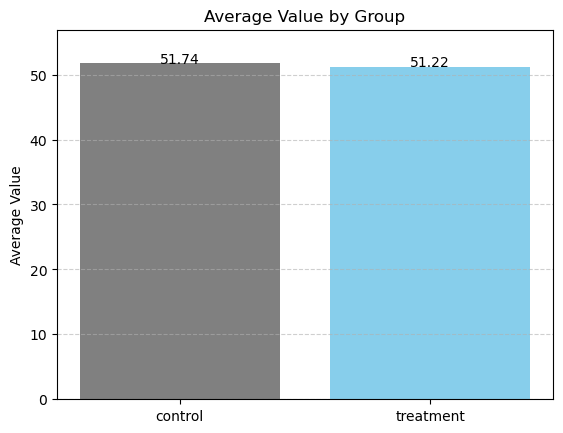

In [36]:
plot_ab_test_results(result)

#### 95% Confidence Intervals (`outcome of group`)

- The 95% confidence interval gives a range in which we expect the **true conversion rate** to fall for each group.
- If the confidence intervals **do not overlap**, it's strong evidence that the difference is statistically significant.
- If they **do overlap**, it doesn't guarantee insignificance — you still need the p-value to decide — but it suggests caution when interpreting lift.

In [37]:
# # Compute confidence intervals
# def compute_ci(p, n, z=1.96):
#     se = np.sqrt(p * (1 - p) / n)
#     return (p - z*se, p + z*se)

# ci_control = compute_ci(control_conv, n_control)
# ci_treatment = compute_ci(treatment_conv, n_treatment)

# # Plot with error bars
# plt.errorbar(['Control', 'Treatment'],
#              [control_conv, treatment_conv],
#              yerr=[[control_conv - ci_control[0], treatment_conv - ci_treatment[0]],
#                    [ci_control[1] - control_conv, ci_treatment[1] - treatment_conv]],
#              fmt='o', capsize=10, color='black')
# plt.ylabel('Conversion Rate');
# plt.title('Conversion Rate with 95% Confidence Intervals');
# plt.grid(axis='y', linestyle='--', alpha=0.7);
# plt.show();

In [38]:
def plot_confidence_intervals(result, z=1.96):
    """
    Plot 95% confidence intervals for group means (conversion rate or average outcome).
    
    Parameters:
    - result: dictionary returned by run_ab_test()
    - z: Z-score for confidence interval (default: 1.96 for 95%)
    """
    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']
    summary = result['summary']
    
    if exp_type not in ['binary', 'continuous_independent', 'continuous_paired']:
        print(f"⚠️ Confidence interval plotting not supported for experiment_type: {exp_type}")
        return

    # Extract values
    p1 = summary[group1]['mean']
    p2 = summary[group2]['mean']
    n1 = summary[group1]['n']
    n2 = summary[group2]['n']

    if exp_type == 'binary':
        # Standard error for proportions
        se1 = np.sqrt(p1 * (1 - p1) / n1)
        se2 = np.sqrt(p2 * (1 - p2) / n2)
        ylabel = "Conversion Rate"
        title = "Conversion Rate with 95% Confidence Intervals"
    else:
        # Use std if available
        sd1 = summary[group1].get('std')
        sd2 = summary[group2].get('std')
        if sd1 is None or sd2 is None:
            print("⚠️ Standard deviation not available — cannot compute CI for continuous data.")
            return
        se1 = sd1 / np.sqrt(n1)
        se2 = sd2 / np.sqrt(n2)
        ylabel = "Mean Outcome"
        title = f"{ylabel} with 95% Confidence Intervals"

    # Confidence intervals
    ci1 = (p1 - z * se1, p1 + z * se1)
    ci2 = (p2 - z * se2, p2 + z * se2)

    # Plot
    plt.errorbar([group1, group2],
                 [p1, p2],
                 yerr=[[p1 - ci1[0], p2 - ci2[0]],
                       [ci1[1] - p1, ci2[1] - p2]],
                 fmt='o', capsize=10, color='black')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


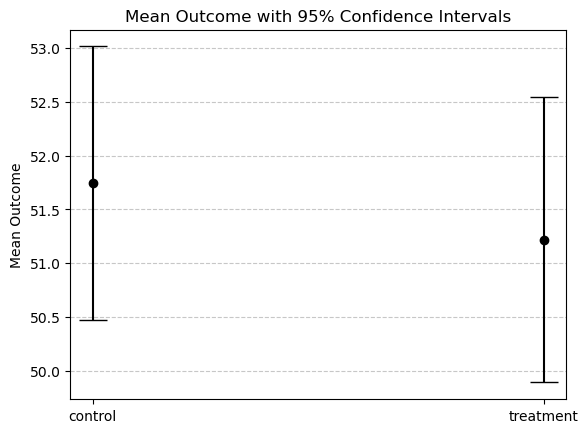

In [39]:
plot_confidence_intervals(result)


#### 95% Confidence Intervals (`difference in outcomes`). AKA `Lift Analysis`

In [43]:
import numpy as np

def compute_lift_confidence_interval(result):
    """
    Computes and interprets the confidence interval for the difference in outcomes (lift)
    based on experiment type.

    Parameters:
    - result: dictionary returned by run_ab_test()

    Output:
    - Prints lift summary and 95% confidence interval (when applicable)
    """

    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']
    alpha = result.get('alpha', 0.05)
    z = 1.96  # For 95% confidence

    print("\n" + "="*45)
    print(f"📈 95% CI for Difference in Outcome [{exp_type}]")
    print("="*45)

    if exp_type in ['binary', 'continuous_independent']:
        mean1 = result['summary'][group1]['mean']
        mean2 = result['summary'][group2]['mean']
        lift = mean2 - mean1
        n1 = result['summary'][group1]['n']
        n2 = result['summary'][group2]['n']

        if exp_type == 'binary':
            # SE for difference in proportions
            se_diff = np.sqrt(mean1 * (1 - mean1) / n1 + mean2 * (1 - mean2) / n2)
        else:  # continuous_independent
            sd1 = result['summary'][group1].get('std')
            sd2 = result['summary'][group2].get('std')
            if sd1 is None or sd2 is None:
                print("⚠️ Standard deviation missing. Cannot compute CI.")
                return
            se_diff = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)

        ci_low = lift - z * se_diff
        ci_high = lift + z * se_diff

        print(f"- Absolute Lift         : {lift:.4f}")
        print(f"- 95% Confidence Interval: [{ci_low:.4f}, {ci_high:.4f}]")

        if ci_low > 0:
            print("✅ We’re 95% confident the treatment improved the outcome.")
        elif ci_high < 0:
            print("🚫 We’re 95% confident the treatment worsened the outcome.")
        else:
            print("🤷 The CI includes 0 — result is not statistically significant.")

    elif exp_type == 'continuous_paired':
        print("- Paired t-test was used, which internally accounts for paired differences.")
        print("- The test already captures variance of differences directly.")
        print("- ✅ You may optionally compute CI using the standard error of the differences (not included here).")

    elif exp_type == 'categorical':
        print("- This test compares distributions across multiple categories (e.g., plan_type or country).")
        print("- There isn’t a single 'lift' value.")
        print("- To compute per-category lift and confidence intervals:")
        print("    → Get proportion of users in each category for control and treatment.")
        print("    → Compute difference (lift) for each category.")
        print("    → Use formula for difference in proportions to estimate CI for each.")
        print("⚠️ Placeholder: Categorical CI calculations not included yet.")

    else:
        print(f"⚠️ Unsupported experiment type: {exp_type}")

    print("="*45 + "\n")


In [44]:
compute_lift_confidence_interval(result)



📈 95% CI for Difference in Outcome [continuous_independent]
- Absolute Lift         : -0.5225
- 95% Confidence Interval: [-2.3624, 1.3175]
🤷 The CI includes 0 — result is not statistically significant.



#### Final Conclusion

In [46]:
def print_final_ab_test_summary(result):
    """
    Prints a final summary block for A/B test results based on experiment type.
    """
    exp_type = result['experiment_type']
    group1, group2 = result['group_labels']
    p_value = result.get('p_value')
    alpha = result.get('alpha', 0.05)
    
    print("="*40)
    print("          📊 FINAL A/B TEST SUMMARY")
    print("="*40)

    # For experiment types where group means are meaningful
    if exp_type in ['binary', 'continuous_independent']:
        mean1 = result['summary'][group1]['mean']
        mean2 = result['summary'][group2]['mean']
        lift = mean2 - mean1
        pct_lift = lift / mean1 if mean1 else np.nan

        label = "Conversion rate" if exp_type == 'binary' else "Avg outcome"
        test_name = result.get("test", "A/B test")

        print(f"👥  {group1.capitalize()} {label:<20}:  {mean1:.4f}")
        print(f"🧪  {group2.capitalize()} {label:<20}:  {mean2:.4f}")
        print(f"📈  Absolute lift              :  {lift:.4f}")
        print(f"📊  Percentage lift            :  {pct_lift:.2%}")
        print(f"🧪  P-value (from {test_name}) :  {p_value:.4f}")

    elif exp_type == 'continuous_paired':
        print("🧪 Paired T-Test was used to compare outcomes within the same users.")
        print(f"🧪 P-value: {p_value:.4f}")

    elif exp_type == 'categorical':
        print("🧪 Chi-square test was used to compare categorical distributions.")
        print(f"🧪 P-value: {p_value:.4f}")

    else:
        print("⚠️ Unknown experiment type.")

    print("-" * 40)

    # Verdict
    if p_value is not None:
        if p_value < alpha:
            print("✅ RESULT: Statistically significant difference detected.")
        else:
            print("❌ RESULT: No statistically significant difference detected.")
    else:
        print("⚠️ No p-value to determine significance.")

    print("="*40 + "\n")


In [47]:
print_final_ab_test_summary(result)


          📊 FINAL A/B TEST SUMMARY
👥  Control Avg outcome         :  51.7431
🧪  Treatment Avg outcome         :  51.2206
📈  Absolute lift              :  -0.5225
📊  Percentage lift            :  -1.01%
🧪  P-value (from independent t-test) :  0.5779
----------------------------------------
❌ RESULT: No statistically significant difference detected.



[Back to the top](#Contents)
___


# How Long
##### to run the test?


The runtime of an A/B test depends on how quickly you can reach the required **sample size per group**, as estimated during power analysis.

##### Key Inputs:
- ✅ Daily eligible traffic volume
- ✅ Required sample size (from power analysis)
- ✅ Whether traffic is split 50/50 or unevenly

##### Formula:
> **Days = Required Sample Size per Group / (Daily Eligible Users × Group Split Proportion)**

This ensures the experiment runs **long enough to detect the effect** with the desired statistical confidence.

##### ⏳ How Long to Run an A/B Test — Real-World Guide

1. **Estimate sample size** needed (done via power analysis)
2. **Understand your traffic** — how many eligible users per day?
3. **Factor in group split** — if it's 50/50, each group gets half the traffic
4. **Divide required sample per group by daily users per group** to estimate days

---

##### 💡 Real-World Recommendations

- ✅ **Ramp-Up Period**: Don’t go full traffic on Day 1. Start with 5%, then 25%, then 50% over 2–3 days. This is safer and helps catch bugs early.
  
- ✅ **Cool-Down Buffer**: Let the test stabilize before analysis. Avoid cutting off during weekends or anomalies.
  
- ✅ **Trust Checks**:
  - Run an **A/A test first** to validate setup
  - Do an **SRM check** to confirm assignment balance
  - Monitor **guardrail metrics** (e.g., bounce rate, latency)

- ⏳ Add **1–2 buffer days** for these. It’s not just about stats — it’s about reliability and business trust.

---

##### 🧠 Tip
> “We typically recommend calculating sample size from power analysis, then dividing by daily traffic per variant. But we also factor in buffer days for ramp-up, trust checks, and traffic noise — just to make sure we don’t rush analysis before data is stable.”

> “We use power analysis to plan — it gives stakeholders a timeline and sets expectations.
But we don’t blindly stop based on sample size. I monitor SRM, metric stability, cohort coverage, and confidence intervals before making the call. We want decisions that are trustworthy, not just statistically complete.”

In [ ]:
def estimate_total_test_duration(required_sample_size_per_group, daily_eligible_users, allocation_ratio=0.5):
    """
    Estimate total days needed to complete an A/B test for both groups.

    Parameters:
    - required_sample_size_per_group: int, sample size needed per group (from power analysis)
    - daily_eligible_users: int, total eligible users arriving each day
    - allocation_ratio: float, proportion of traffic sent to each group (e.g., 0.5 for 50/50)

    Returns:
    - Estimated total number of days to complete both groups
    """
    # Max group load per day (assuming symmetric or asymmetric allocation)
    daily_users_per_group = daily_eligible_users * allocation_ratio
    days_needed = required_sample_size_per_group / daily_users_per_group

    return int(np.ceil(days_needed))

# Example Usage
required_sample = 3532
daily_users = 10000
allocation = 0.5  # 50% of users per group

total_days = estimate_total_test_duration(required_sample, daily_users, allocation)
buffer_days = 2  # For ramp-up, cool-down, or traffic anomalies

print(f"📅 Estimated minimum duration per group : {total_days} days")
print(f"📦 Add buffer (ramp-up, weekends, trust checks): {buffer_days} days")
print(f"🧮 Total recommended runtime             : {total_days + buffer_days} days\n")


#### Monitoring Dashboard
- Guardrails
-

[Back to the top](#Contents)
___


# Post Hoc Analysis

> 🔍 After statistical significance, we do a post-hoc dive. We check for lift by user segment, inspect guardrail metrics, and simulate rollout impact. This turns A/B tests into real product decisions.

Post-hoc analysis helps interpret test results **beyond the primary metric**, and answer key follow-up questions like:
- Did the effect differ by segment (e.g. platform, user type)?
- Were any guardrail metrics negatively impacted?
- What does the lift mean in terms of actual revenue or conversions?
- What happens if we roll this out 100%?

This step helps turn **statistical significance into business confidence.**

#### Segmented Lift

In [ ]:
# Let's add a few realistic segmentation features to the users DataFrame
# (e.g., platform, device_type, user_tier, region)

np.random.seed(my_seed)  # for reproducibility

users['platform'] = np.random.choice(['iOS', 'Android'], size=len(users))
users['device_type'] = np.random.choice(['mobile', 'desktop'], size=len(users), p=[0.7, 0.3])
users['user_tier'] = np.random.choice(['new', 'returning'], size=len(users), p=[0.4, 0.6])
users['region'] = np.random.choice(['North', 'South', 'East', 'West'], size=len(users))

# Return a preview of the updated DataFrame
users.head()

In [ ]:
def segmented_lift_analysis(df, segment_cols, outcome_col='converted'):
    for segment in segment_cols:
        print(f"\n📊 Segment: {segment}")
        print("-" * 40)

        # 1. Aggregate conversion metrics
        grouped = df.groupby([segment, 'group'])[outcome_col].agg(['count', 'sum', 'mean']).reset_index()
        grouped.columns = [segment, 'group', 'n_users', 'n_converted', 'conversion_rate']

        # 2. Pivot to calculate absolute and percentage lift
        pivoted = grouped.pivot(index=segment, columns='group', values='conversion_rate').reset_index()
        pivoted['absolute_lift'] = pivoted['treatment'] - pivoted['control']
        pivoted['percentage_lift'] = pivoted['absolute_lift'] / pivoted['control']
        print(pivoted[[segment, 'control', 'treatment', 'absolute_lift', 'percentage_lift']].to_string(index=False))

        # 3. Plot
        plt.figure(figsize=(10, 4))
        ax = sns.barplot(data=grouped, x=segment, y='conversion_rate', hue='group')

        # 4. Add value labels
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f"{height:.3f}", 
                        (bar.get_x() + bar.get_width() / 2, height + 0.005),
                        ha='center', va='bottom', fontsize=9)

        # 5. Style tweaks — fixed layout
        ax.set_title(f'Conversion Rate by {segment} and Group', pad=15)
        ax.set_ylabel('Conversion Rate')
        ax.set_xlabel(segment)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.set_ylim(0, grouped['conversion_rate'].max() + 0.05)

        # 👇 FIXED LEGEND POSITION
        ax.legend(
            # title='Group', 
            loc='upper right', 
            fontsize='small', 
            title_fontsize='small',
            frameon=True,
            borderpad=0.5)

        plt.tight_layout()
        plt.show()

In [ ]:
segmented_columns = ['platform', 'device_type', 'user_tier', 'region']
segmented_lift_analysis(users, segmented_columns)

#### Guardrail Metric Checks

Guardrail metrics are **non-primary metrics** that help ensure an experiment isn't causing unintended harm.

We monitor them alongside the main success metric to:
- Detect regressions in user experience or system performance
- Catch trade-offs early (e.g., improved conversions but worse bounce rate)

---

📊 Common Guardrail Metrics
- Bounce Rate — did the experience frustrate users?
- Page Load Time / Latency — did the feature slow down the UI?
- Session Length / Engagement — did users stick around?
- Error Rate — did the experiment introduce bugs?

---

✅ When to Act:
- If the **treatment worsens a guardrail metric**, even if the primary metric improved → we pause, investigate, or reject the rollout.
Guardrails aren’t always deal-breakers, but they’re **trust checks** that make A/B test results *safe* to act on.

In [ ]:
# Add a simulated guardrail metric: bounce_rate (continuous between 0.1 and 0.9)
# Bounce rate is typically higher when users disengage quickly

np.random.seed(my_seed)
users['bounce_rate'] = np.where(
    users['converted'] == 1,
    np.random.normal(loc=0.2, scale=0.05, size=len(users)),  # lower bounce if converted
    np.random.normal(loc=0.6, scale=0.1, size=len(users))   # higher bounce if not
)

# Clip to stay between 0 and 1
users['bounce_rate'] = users['bounce_rate'].clip(0, 1)

# Return sample for inspection
users.head()

In [ ]:
# Example if you had bounce_rate as a column:
guardrail = users.groupby('group')['bounce_rate'].mean()
print("🚦 Average Bounce Rate by Group:")
print(guardrail)

In [ ]:
# 1. Group means
bounce_by_group = users.groupby('group')['bounce_rate'].mean()
bounce_diff = bounce_by_group['treatment'] - bounce_by_group['control']

# 2. Optional statistical test (t-test)
control_bounce = users[users['group'] == 'control']['bounce_rate']
treatment_bounce = users[users['group'] == 'treatment']['bounce_rate']
t_stat, p_val = ttest_ind(treatment_bounce, control_bounce)

# 3. Print summary and conclusion
print("🚦 Guardrail Check")
print(f"- Control  : {bounce_by_group['control']:.4f}")
print(f"- Treatment: {bounce_by_group['treatment']:.4f}")
print(f"- Difference: {bounce_diff:+.4f}")
print(f"- P-value (t-test): {p_val:.4f}")

# 4. Conclusion
if p_val < 0.05:
    if bounce_diff > 0:
        print("❌ Statistically significant *increase* in bounce rate — potential UX regression.")
    else:
        print("✅ Statistically significant *decrease* in bounce rate — UX may have improved.")
else:
    print("🟡 No significant change in bounce rate — guardrail looks stable.")

#### Rollout Simulation

In [ ]:
# Assume full exposure to daily_eligible_users
daily_impact = (treatment_conv - control_conv) * daily_eligible_users
monthly_impact = daily_impact * 30

print(f"📈 Estimated additional conversions per day: {daily_impact:.0f}")
print(f"📈 Estimated additional conversions per month: {monthly_impact:.0f}")

[Back to the top](#Contents)
___


# Scratch Notes


In [ ]:
# Simulate data
n_control = 5000  # Sample size for control group
n_treatment = 5000  # Sample size for treatment group

# Assume conversion rate is 10% for control and 12% for treatment
control_conversions = np.random.binomial(1, 0.10, n_control)
treatment_conversions = np.random.binomial(1, 0.12, n_treatment)

# Create DataFrame
df = pd.DataFrame({
    'group': ['control'] * n_control + ['treatment'] * n_treatment,
    'conversion': np.concatenate([control_conversions, treatment_conversions])
})
df.head()
df.shape

# Display summary
df.groupby('group')['conversion'].agg(['mean', 'count', 'sum'])


#### AB Testing

1. Chi-Square Test (Categorical Data - Conversion Rates)     
Used when testing differences in proportions (e.g., conversion rate increase).

In [ ]:
# Create contingency table
conversion_table = pd.crosstab(df['group'], df['conversion'])

# Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(conversion_table)

# Print results
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Check significance
alpha = 0.05  # 95% confidence level
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference detected.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")


2. Independent T-Test (Continuous Data - Avg. Time Spent, Revenue)    
Used when comparing means of continuous data between two independent groups.

In [ ]:
# Perform independent t-test
t_stat, p_val = ttest_ind(control_conversions, treatment_conversions)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < alpha:
    print("Reject the null hypothesis: The new feature has a significant effect.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")


3. Paired T-Test (Before/After Tests - Same Users)    
Used when measuring differences within the same group (e.g., before vs. after).

In [ ]:
# Example: User engagement before & after a UI change
before = np.random.normal(200, 25, 100)  # Mean 200 sec, std dev 25
after = np.random.normal(210, 25, 100)  # Mean 210 sec, std dev 25

t_stat, p_val = ttest_rel(before, after)

print(f"Paired T-Test Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("Significant difference detected.")
else:
    print("No significant difference detected.")

4. Mann-Whitney U Test (Non-Normal Continuous Data)
A non-parametric test used when data isn’t normally distributed (e.g., skewed revenue).

In [ ]:
# Example: Revenue data (skewed distribution)
control_revenue = np.random.exponential(50, 5000)  # Skewed
treatment_revenue = np.random.exponential(55, 5000)  # Skewed

u_stat, p_val = mannwhitneyu(control_revenue, treatment_revenue)

print(f"Mann-Whitney U Statistic: {u_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("Significant difference detected.")
else:
    print("No significant difference detected.")


 5. Bayesian A/B Testing (Alternative Approach)    
Instead of p-values, Bayesian A/B testing provides posterior probability distributions.

In [ ]:
# import pymc3 as pm

# # Simulated conversion data
# control_conversions = np.sum(np.random.binomial(1, 0.10, 5000))
# treatment_conversions = np.sum(np.random.binomial(1, 0.12, 5000))

# with pm.Model():
#     control_rate = pm.Beta("control_rate", alpha=1, beta=1)
#     treatment_rate = pm.Beta("treatment_rate", alpha=1, beta=1)

#     # Priors
#     control = pm.Binomial("control", n=5000, p=control_rate, observed=control_conversions)
#     treatment = pm.Binomial("treatment", n=5000, p=treatment_rate, observed=treatment_conversions)

#     trace = pm.sample(2000, return_inferencedata=True)

# # Compute probability that the treatment is better
# prob_treatment_better = (trace.posterior["treatment_rate"] > trace.posterior["control_rate"]).mean().item()

# print(f"Probability that the treatment is better: {prob_treatment_better:.4f}")


6. Power Analysis (How Much Data Do You Need?)
Used to determine sample size before running an experiment.

In [ ]:
# Define parameters
effect_size = 0.02  # Expected lift in conversion rate
alpha = 0.05  # Significance level
power = 0.8  # Desired statistical power

# Compute sample size per group
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, alpha=alpha, ratio=1)

print(f"Required Sample Size per Group: {int(sample_size)}")

# Other Notes

### Experimentation Infrastructure

[Back to the top](#Contents)
___